In [37]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


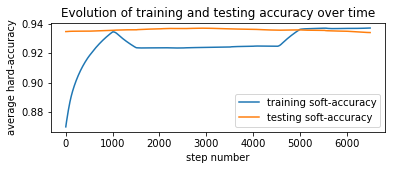

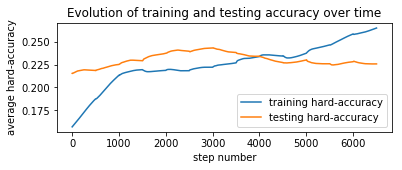

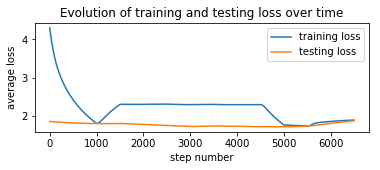

In [367]:
end_data = 9
is_10K = False
babi_task = 3
fname = '3_metadata_stat_extract_1k_memvecdmn_1'
smooth_nbr = 3500
figure_name=('Final_memvec_1k_%ssm_%sbt' %(smooth_nbr, babi_task))
train_epoch = []
train_cu_loss = []
train_avg_loss = []
train_cu_acc = []
train_avg_acc = []
train_avg_hard_acc = []
train_avg_indi_acc = []

test_epoch = []
test_cu_loss = []
test_avg_loss = []
test_cu_acc = []
test_avg_acc = []
test_avg_hard_acc = []
test_avg_indi_acc = []

train_epoch, train_avg_acc, train_avg_loss, train_avg_indi_acc, train_avg_hard_acc, test_epoch, test_avg_acc, test_avg_loss, test_avg_indi_acc, test_avg_hard_acc = create_data(fname, end_data,is_10K, smooth_nbr=smooth_nbr)

#create_indi_figure([6], train_epoch, train_avg_indi_acc,test_avg_indi_acc, figure_name, is_10K, smooth_nbr, testing_only=True)
create_figure(train_epoch, train_avg_acc, train_avg_loss, train_avg_hard_acc, test_epoch, test_avg_acc, test_avg_loss, test_avg_hard_acc,name=figure_name, is_10K=is_10K)

In [346]:
def extract_indi_resuts(li):
    
    final_l = []
    t = li.split(" ")
    for i in range(0, np.shape(t)[0]):
        if("." in t[i]):
            if("]" in t[i]):
                t[i] = t[i][:len(t[i]) - 1]
            temp = float(t[i])
            final_l.append(temp)
    return final_l
    

def extract_results(fname, end_data_data, is_10k):
    train_hard_acc1 = []
    train_hard_acc2 = []
    
    test_hard_acc1 = []
    test_hard_acc2 = []
    prev_e = 0
    prev_t = 0
    
    if(is_10K):
        duplicate = 10
    else:
        duplicate = 1
    train_name = (('EDMN-theano/output_data/train_babi%s.csv' %fname))
    test_name = (('EDMN-theano/output_data/test_babi%s.csv' %fname))
    with open(train_name) as f:
        reader = csv.reader(f)
        hard_acc_avg = 0.0
        i=0
        for l in reader:
            i = i + 1
            if(len(l)>=6):
                e = float(l.pop(0)) #epoch_nbr
                if(e!=prev_e):
                    hard_acc_avg = 0
                prev_e = e
                
                if(e<=end_data):# and i%10==0):
                    step_nbr = float(l.pop(0)) #step-nbr
                    mul_fact = 1000
                    if(is_10K):
                        mul_fact = 10000
                    train_epoch.append(e*mul_fact + step_nbr)
                    train_cu_loss.append(l.pop(0)) #current_loss
                    avg_l = float(l.pop(0)) #avg_loss
                    train_avg_loss.append(avg_l)
                    soft_cu_acc = float(l.pop(0)) #current_acc
                    train_cu_acc.append(soft_cu_acc) #softacc_cu
                    train_avg_acc.append(l.pop(0)) #avg_soft_acc
                    train_hard_acc1.append(float(l.pop(0))) #normally hard_acc but...
                    if(train_cu_acc[-1]==1):
                        hard_acc_avg += 1.0
                    train_hard_acc2.append(hard_acc_avg/(step_nbr + 1))
                    train_avg_indi_acc.append(extract_indi_resuts(l.pop())) #indi results, tab
                    
    temp = np.zeros(np.shape(train_hard_acc1))
    temp = temp == train_hard_acc1
    if(False in temp):
        train_avg_hard_acc = train_hard_acc1
    else:
        train_avg_hard_acc = train_hard_acc2
        print("training: no hard acc found. Using safe calculated one!")

    with open(test_name) as f:
        reader = csv.reader(f)
        hard_acc_avg_t = 0.0
        counter = 1
        for l in reader:
            if(len(l)>=6):
                t = float(l.pop(0))#epoch_nbr
                if(t!=prev_t):
                    hard_acc_avg_t = 0
                prev_t = t
                if(t<=end_data):
                    temp = []
                    temp.append(l.pop(0)) #step nbr
                    temp.append(l.pop(0)) #currentloss
                    temp.append(l.pop(0)) #avg_loss
                    temp.append(l.pop(0)) #current acc
                    temp.append(l.pop(0)) #avg acc
                    temp.append(l.pop(0)) #hard acc but ...
                    temp.append(l.pop(0)) #indi acc
                    if(float(temp[3])==1):
                        hard_acc_avg_t+=1.0
                    hardacc_temp = hard_acc_avg_t/(float(temp[0]) + 1)
                    counter = counter + 1

                    for i in range(0,duplicate):
                        test_epoch.append(t*mul_fact + float(temp[0]))
                        test_cu_loss.append(temp[1])
                        test_avg_loss.append(temp[2])
                        test_cu_acc.append(float(temp[3]))
                        test_avg_acc.append(temp[4])
                        test_hard_acc1.append(float(temp[5]))#/(float(temp[0]) + 1))
                        test_hard_acc2.append(hardacc_temp)
                       
                        test_avg_indi_acc.append(extract_indi_resuts(temp[6]))
    temp = np.zeros(np.shape(test_hard_acc1))
    temp = temp == test_hard_acc1
    if(False in temp):
        test_avg_hard_acc = test_hard_acc1
    else:
        test_avg_hard_acc = test_hard_acc2
        print("testing: no hard acc found. Using safe calculated one!")

    return train_epoch, train_avg_acc, train_avg_loss, train_avg_indi_acc, train_avg_hard_acc, test_epoch, test_avg_acc, test_avg_loss, test_avg_indi_acc, test_avg_hard_acc

In [222]:
import csv
def create_data(fname, end_data,is_10k, smooth_nbr=1):

    train_epoch, train_avg_acc, train_avg_loss, train_avg_indi_acc, train_avg_hard_acc, test_epoch, test_avg_acc, test_avg_loss, test_avg_indi_acc, test_avg_hard_acc = extract_results(fname, end_data, is_10K)
    
    test_avg_acc = test_avg_acc[0:len(train_avg_acc)]
    test_avg_loss = test_avg_loss[0:len(train_avg_loss)]

    train_avg_acc = smoother(train_avg_acc, smooth_nbr)[:len(train_avg_acc) - smooth_nbr]
    test_avg_acc = smoother(test_avg_acc, smooth_nbr)[:len(test_avg_acc) - smooth_nbr]
    train_avg_loss = smoother(train_avg_loss, smooth_nbr)[:len(train_avg_loss) - smooth_nbr]
    test_avg_loss = smoother(test_avg_loss, smooth_nbr)[:len(test_avg_loss) - smooth_nbr]
    train_avg_hard_acc = smoother(train_avg_hard_acc, smooth_nbr)[:len(train_avg_hard_acc) - smooth_nbr]
    test_avg_hard_acc = smoother(test_avg_hard_acc, smooth_nbr)[:len(test_avg_hard_acc) - smooth_nbr]
    
    train_epoch = train_epoch[:len(train_epoch) - smooth_nbr]
        

    return train_epoch, train_avg_acc, train_avg_loss, train_avg_indi_acc, train_avg_hard_acc, test_epoch, test_avg_acc, test_avg_loss, test_avg_indi_acc, test_avg_hard_acc

In [299]:
def create_figure(train_epoch, train_avg_acc, train_avg_loss, train_hard_acc, test_epoch, test_avg_acc, test_avg_loss, test_hard_acc, name='', is_10K=False):
    plt.figure()
    plt.figure(figsize=(6,2))
    plt.plot(train_epoch, train_avg_acc, label="training soft-accuracy")
    plt.plot(train_epoch, test_avg_acc, label="testing soft-accuracy")
    plt.legend()
    plt.xlabel("step number")
    plt.ylabel("average soft-accuracy")
    if(is_10K):
        plt.title("Evolution of training and testing accuracy over time (10k)")
    else:
        plt.title("Evolution of training and testing accuracy over time")
    temp = ('results/avg_acc_%s.jpg' %name)
    #
    plt.draw()
    plt.savefig(temp)

    plt.figure()
    plt.figure(figsize=(6,2))
    plt.plot(train_epoch, train_hard_acc, label="training hard-accuracy")
    plt.plot(train_epoch, test_hard_acc, label="testing hard-accuracy")
    plt.legend()
    plt.xlabel("step number")
    plt.ylabel("average hard-accuracy")
    if(is_10K):
        plt.title("Evolution of training and testing accuracy over time (10k)")
    else:
        plt.title("Evolution of training and testing accuracy over time")
    temp = ('results/avg_hard-acc_%s.jpg' %name)
    #plt.figure(figsize=(6,2))
    plt.draw()
    plt.savefig(temp)

    plt.figure()
    plt.figure(figsize=(6,2))
    plt.plot(train_epoch, train_avg_loss, label="training loss")
    plt.plot(train_epoch, test_avg_loss, label="testing loss")
    plt.legend()
    plt.xlabel("step number")
    plt.ylabel("average loss")
    if(is_10K):
        plt.title("Evolution of training and testing loss over time (10k)")
    else:
        plt.title("Evolution of training and testing loss over time")
    temp = ('results/avg_loss_%s.jpg' %name)
    #plt.figure(figsize=(6,2))
    plt.draw()
    plt.savefig(temp)

In [8]:
def smoother(l, nbr=2):
    new_l = l
    for i in range(0,np.shape(l)[0]-nbr+1):
        new_l[i] = float(l[i])
        for j in range(1, nbr):
            new_l[i] = new_l[i] + float(l[i+j])
        new_l[i] = new_l[i]/nbr
    return new_l

In [355]:
def create_indi_figure(idx_to_create, train_epoch, train_indi_acc, test_indi_acc, name, is_10k, smooth_nbr, testing_only=False):
    
    plt.figure()
    plt.figure(figsize=(6,2))
    for a in idx_to_create:
        if(not testing_only):
            tlabel = str("training accuracy, idx %s" %a)
            temp = extract_data_from_indi(train_indi_acc, a)
            plt.plot(train_epoch, temp, label=tlabel)
        tlabel = str("testing accuracy, idx %s" %a)
        temp = extract_data_from_indi(test_indi_acc, a)
        plt.plot(train_epoch,temp, label=tlabel)
    plt.legend()
    plt.xlabel("step number")
    plt.ylabel("average accuracy")
    if(is_10K):
        plt.title("Evolution of training and testing accuracy over time (10k)")
    else:
        plt.title("Evolution of training and testing accuracy over time")
    #plt.label(loc = 'lower right')
    temp = ('results/avg_indi_acc_%s_%s.jpg' %(name, idx_to_create))
    plt.savefig(temp)
    
def extract_data_from_indi(indi_list, idx):
    temp = []
    for i in range(0, np.shape(indi_list)[0]):
        temp.append(indi_list[i][idx])
    temp = smoother(temp, smooth_nbr)[:len(temp) - smooth_nbr]
    return temp